### Project Details

* DOMAIN: Entertainment

* CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene.

* DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
* PROJECT OBJECTIVE: Face detection from training images.

### Attributions

* Dataset : http://shuoyang1213.me/WIDERFACE/
* MobileNet paper : https://arxiv.org/pdf/1704.04861.pdf

### Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html#:~:text=A%20patch%20is%20a%202D,Description
from PIL import Image
import csv

In [ ]:
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
#https://paperswithcode.com/method/global-average-pooling#:~:text=Global%20Average%20Pooling%20is%20a,in%20the%20last%20mlpconv%20layer.
#https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
from keras.layers import RepeatVector,Conv1D,Flatten,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon #Returns a fuzz factor(1e-7)
import tensorflow as tf
import tensorflow
from keras.applications.resnet50 import ResNet50,preprocess_input

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Loading the dataset from npy file

In [ ]:
data = np.load('/content/drive/MyDrive/glearn/ACV/Dataset- Images.npy', allow_pickle=True)

In [ ]:
data.shape

(409, 2)

### The first image

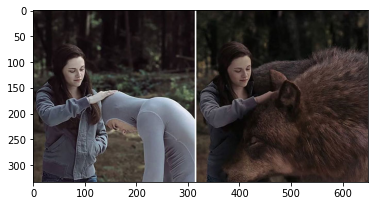

In [ ]:
plt.imshow(data[0][0])

### Image Attributes

In [ ]:
data[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

Defining a function for image plotting

In [ ]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Displaying an image from the dataset selected randomly

Image number 162


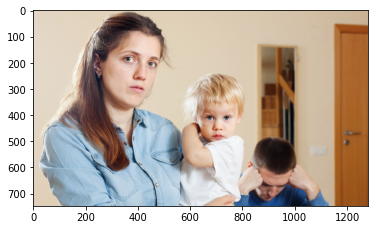

In [ ]:
img_no = np.random.randint(0, data.shape[0])
print("Image number " + str(img_no))
plt.imshow(data[img_no][0])

In [ ]:
data[img_no][1]

[{'imageHeight': 747,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.19233903830480847, 'y': 0.05307262569832402},
   {'x': 0.4001629991850041, 'y': 0.5307262569832403}]},
 {'imageHeight': 747,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4612876935615322, 'y': 0.38268156424581007},
   {'x': 0.6226568867155664, 'y': 0.6675977653631285}]},
 {'imageHeight': 747,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6674816625916871, 'y': 0.6829608938547486},
   {'x': 0.7881010594947025, 'y': 0.9567039106145251}]}]

#### Applying a fixed rectangular mask over an image and noticing the original and masked images together

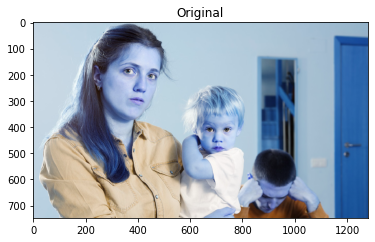

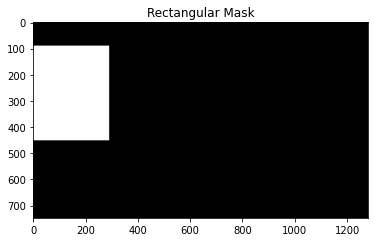

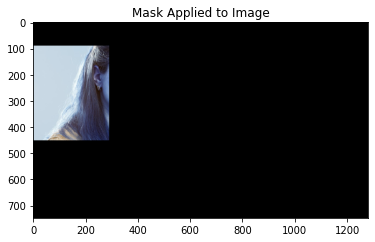

In [ ]:
# load the original input image and display it to our screen
image = data[img_no][0]
plt_imshow("Original", image)

# a mask is the same size as our image, but has only two pixel
# values, 0 and 255 -- pixels with a value of 0 (background) are
# ignored in the original image while mask pixels with a value of
# 255 (foreground) are allowed to be kept
mask = np.zeros(image.shape[:2], dtype="uint8")
cv2.rectangle(mask, (0, 90), (290, 450), 255, -1)
plt_imshow("Rectangular Mask", mask)

# apply our mask -- notice how only the person in the mask is
# cropped out because these are fixed coordinates
masked = cv2.bitwise_and(image, image, mask=mask)
plt_imshow("Mask Applied to Image", masked)

### Define the neccessary parameters

In [ ]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

### Preprocess Image in a format compatible with Mobilenet

In [ ]:
X, y = [],[]

for i, img in enumerate(data):
  resized_img = cv2.resize(img[0], (IMAGE_HEIGHT,IMAGE_WIDTH))
  resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
  #plt_imshow("Original", resized_img)
  X.append(preprocess_input(np.array(resized_img, dtype=np.float32)))

  mask = np.zeros(resized_img.shape[:2], dtype="uint8")

  for face in img[1]:
    if 'Face' in face['label']:
      x1 = np.round(IMAGE_SIZE*face['points'][0]['x'])
      y1 = np.round(IMAGE_SIZE*face['points'][0]['y'])
      x2 = np.round(IMAGE_SIZE*face['points'][1]['x'])
      y2 = np.round(IMAGE_SIZE*face['points'][1]['y'])

      #Draw a filled recatngle on the mask image
      cv2.rectangle(mask, (int(x1),int(y1),int(x2),int(y2)), 255, -1)

  #plt_imshow("Rectangular Mask", mask[0])
  resized_img = cv2.bitwise_and(resized_img, resized_img, mask = mask)
  #plt_imshow("Mask Applied to Image", resized_img)
  #break;
  resized_img = cv2.resize(resized_img, (HEIGHT_CELLS,WIDTH_CELLS))
  resized_img = 1.0*(resized_img[:,:,0]>0.2)
  y.append(np.squeeze(resized_img))

X = np.array(X)
y = np.array(y)

In [ ]:
X.shape, y.shape

((409, 224, 224, 3), (409, 28, 28))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


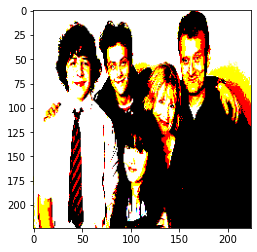

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[6])

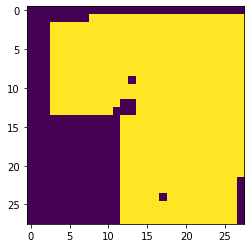

In [ ]:
plt.imshow(y[6])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(306, 224, 224, 3)
(103, 224, 224, 3)
(306, 28, 28)
(103, 28, 28)


## Building the graph

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

## Define Dice Coefficient

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

## Define Loss Function

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

## Create the model and print summary

In [ ]:
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

### Compile the model
- Define optimizer
- Define metrics
- Define loss

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

## Define callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
!pwd

/content


## Fit the model

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=300, batch_size=32, verbose=1, callbacks=[checkpoint])

Epoch 1/300
10/10 [==============================] - 20s 166ms/step - loss: 1.7552 - dice_coefficient: 0.4118 - val_loss: 1.6929 - val_dice_coefficient: 0.4512

Epoch 00001: val_loss improved from inf to 1.69285, saving model to model-1.69.h5
Epoch 2/300
10/10 [==============================] - 0s 45ms/step - loss: 1.6807 - dice_coefficient: 0.4571 - val_loss: 1.6603 - val_dice_coefficient: 0.4678

Epoch 00002: val_loss improved from 1.69285 to 1.66034, saving model to model-1.66.h5
Epoch 3/300
10/10 [==============================] - 0s 44ms/step - loss: 1.6258 - dice_coefficient: 0.4801 - val_loss: 1.6279 - val_dice_coefficient: 0.4690

Epoch 00003: val_loss improved from 1.66034 to 1.62787, saving model to model-1.63.h5
Epoch 4/300
10/10 [==============================] - 0s 44ms/step - loss: 1.6152 - dice_coefficient: 0.4745 - val_loss: 1.5988 - val_dice_coefficient: 0.4685

Epoch 00004: val_loss improved from 1.62787 to 1.59880, saving model to model-1.60.h5
Epoch 5/300
10/10 [===

## Doing predictions on the model we trained

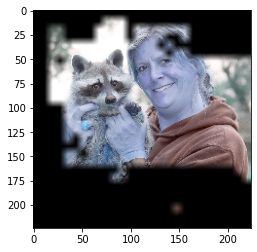

In [ ]:
import matplotlib.pyplot as plt
filename = '/content/drive/MyDrive/glearn/ACV/raccoon-25_prediction_image.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


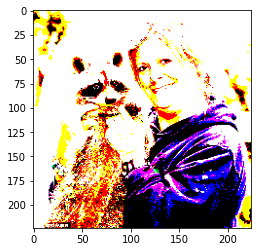

In [ ]:
plt.imshow(feat_scaled)

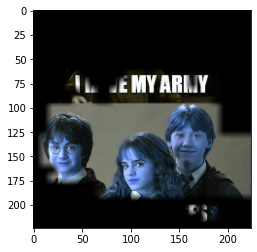

In [ ]:
import matplotlib.pyplot as plt
filename = '/content/drive/MyDrive/glearn/ACV/harry_1.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

Image Attibution : *Pinterest https://in.pinterest.com/pin/726909196083524697/*
This image has been used solely for academic purposes. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


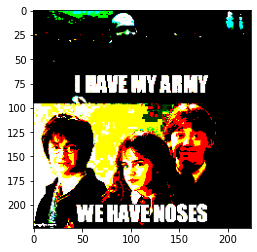

In [ ]:
plt.imshow(feat_scaled)

From predictions, we can see here that the model is overfit but it is doing a decent job of identifying faces more data. In  the first image it is able to identify a female face and a raccoon face but unable to detect "Voldemort" because as we can see the face is not clearly visible once the image is re-scaled into RGB. 

## Using pre-trained weights

In [ ]:
project_path = '/content/'

### Load the model

In [ ]:
WEIGHTS_FILE = project_path + "model-1.16.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

### Run Predictions

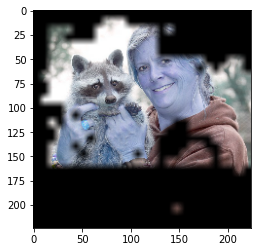

In [ ]:
filename = '/content/drive/MyDrive/glearn/ACV/raccoon-25_prediction_image.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

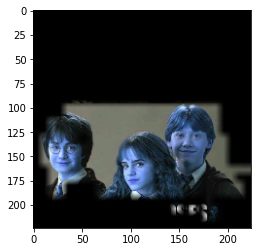

In [ ]:
import matplotlib.pyplot as plt
filename = '/content/drive/MyDrive/glearn/ACV/harry_1.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)